In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap
import optuna

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

In [6]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
plots_dir = "plots"

In [7]:
# File paths for signal and background root files: 
photon_PU0 = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/photons_0PU_bc_stc_hadd.root"
photon_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered_neutrino.h5"

In [8]:
signal_file = uproot.open(photon_PU0)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
#bg_folder = "l1tHGCalTriggerNtuplizer"
tree_name = "HGCalTriggerNtuple"
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [9]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [10]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']

    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    df = df.copy()  # Avoid modifying original DataFrame
    # Filter to keep only clusters with cl3d_energy > 0
    df = df[df['cl3d_ienergy'] > 0]
    # Compute delta_r
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    # Filter based on delta_r threshold
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    # Sort by event_id, cl3d_energy (descending), delta_r (ascending)
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    # Keep only the first occurrence per event_id
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [11]:
# Function to load and filter the tree data (for ROOT file)
def load_and_filter_tree(tree, filter_pt = 20, eta_range=(1.6, 2.8), cl_pt_threshold=5):
    df_gen = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["gen_n", "gen_eta", "gen_phi", "gen_pt", 
                     "genpart_exeta", "genpart_exphi", "event"]
    ))
    df_cl3d = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["*cl3d*", "event"]
    ))
    df_gen_filtered = df_gen[(df_gen['gen_pt'] > filter_pt) & 
                     (abs(df_gen['gen_eta']) > eta_range[0]) & 
                     (abs(df_gen['gen_eta']) < eta_range[1])]
    df_cl3d_filtered = df_cl3d[(abs(df_cl3d['cl3d_eta']) > eta_range[0]) & 
                     (abs(df_cl3d['cl3d_eta']) < eta_range[1]) &
                     (df_cl3d['cl3d_pt'] > cl_pt_threshold)]
    merged_df = pd.merge(
        df_gen_filtered,
        df_cl3d_filtered,
        on="event",
        how="inner",  # Keep only rows where the event ID exists in both
        suffixes=('_gen', '_cl3d')  # Differentiate common column names
    )
    return merged_df

In [12]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [13]:
photonPU0_df = load_and_filter_tree(signal_tree)

In [14]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [15]:
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [16]:
photonPU0_df_filtered = filter_by_delta_r(photonPU0_df)

In [17]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [18]:
neutrinoPU200_df_20GeV = neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [19]:
def plot_delta_r_3d_two_dfs(df, label, eta_col='cl3d_eta', energy_col='cl3d_energy', delta_r_col='delta_r', 
                            colors=('blue', 'red'), cmap = 'plasma', figsize=(12, 8)):
    # Ensure required columns are present
    required_columns = [eta_col, delta_r_col, energy_col]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Create the plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        df[eta_col], df[delta_r_col], c=df[energy_col], cmap=cmap, alpha=0.7, edgecolor='k', s=20
    )
    cbar = plt.colorbar(scatter, label=f"Energy [GeV]")
    # Set axis labels and title
    plt.xlabel("$\eta$ [rad]")
    plt.ylabel("$\Delta$ R [rad]")
    plt.title(f"$\Delta$ R vs $\eta$ for {label}")
    plt.tight_layout()
    filename = os.path.join(plots_dir,f"delta_r_vs_etaenergy_{label.replace(' ', '_')}.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved plot as: {filename}")
    plt.show()

Saved plot as: plots/delta_r_vs_etaenergy_photon_PU0.png


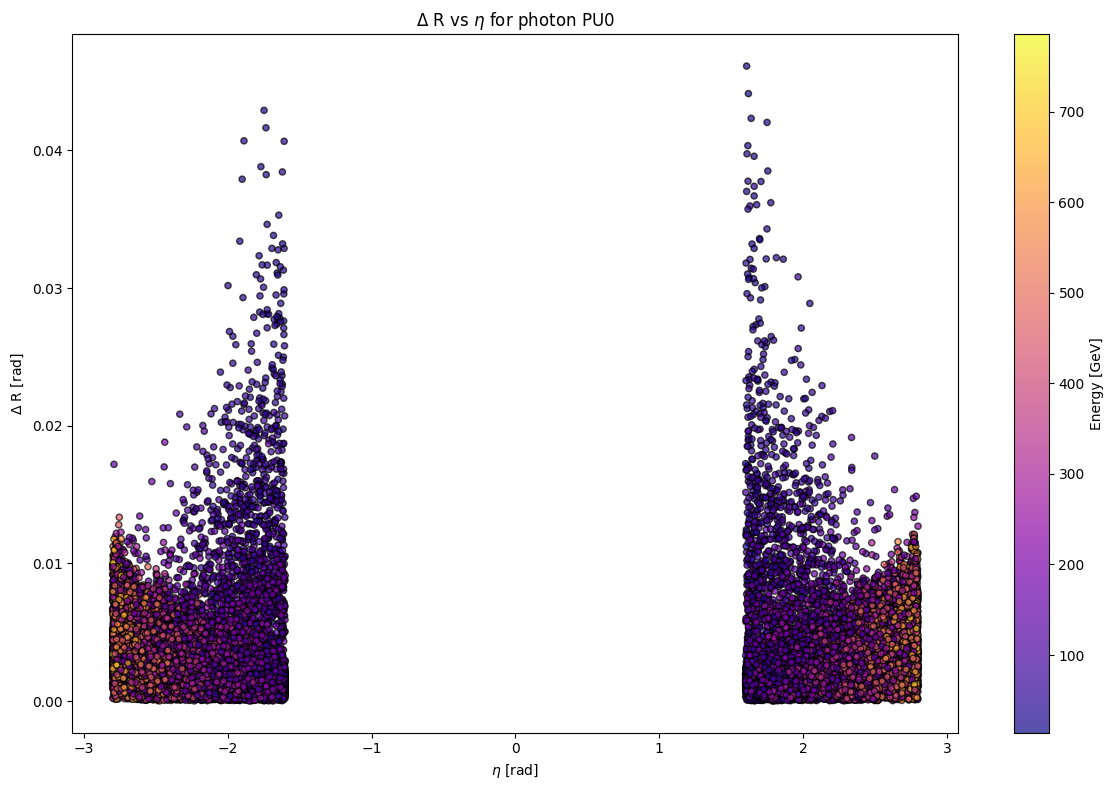

In [20]:
plot_delta_r_3d_two_dfs(photonPU0_df_filtered, 'photon PU0', colors=('blue', 'red'))

Saved plot as: plots/delta_r_vs_etaenergy_photon_PU200.png


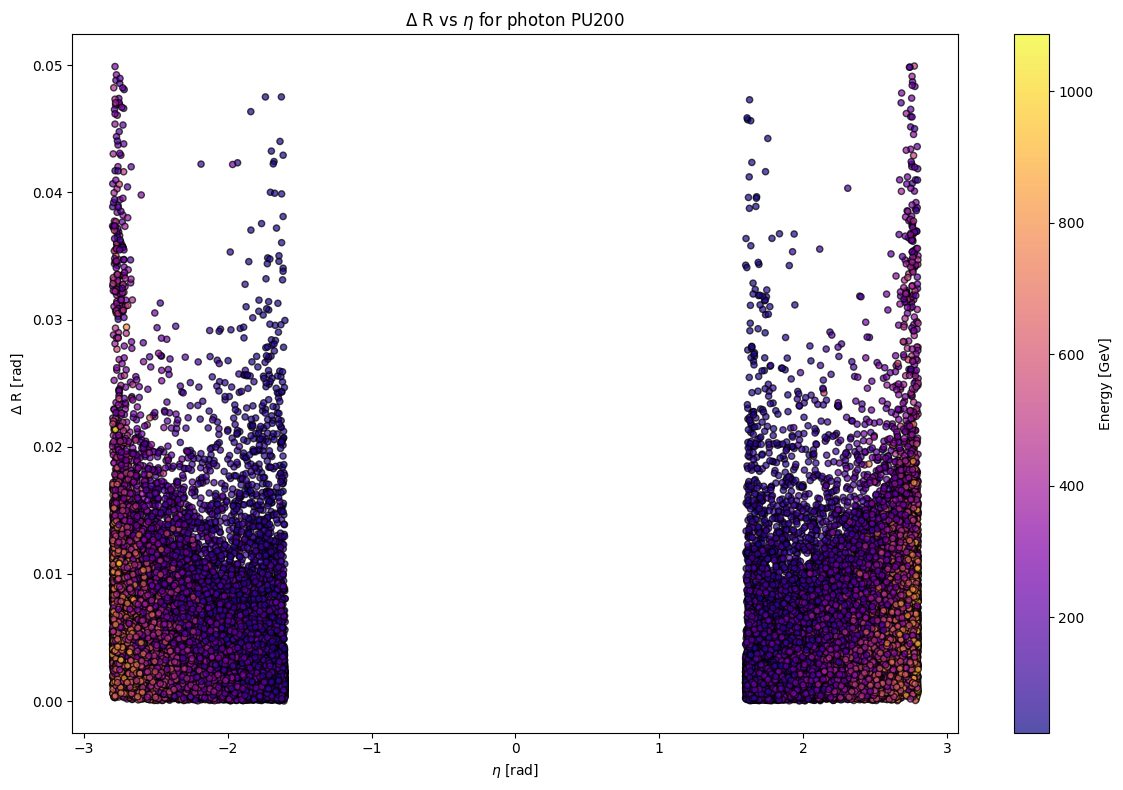

In [21]:
plot_delta_r_3d_two_dfs(photonPU200_df_filtered, 'photon PU200', colors=('blue', 'red'))

In [22]:
def plot_histograms(df_photon_pu200, df_neutrino_pu200, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    df_photon_pu200_filtered = df_photon_pu200[(df_photon_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    df_neutrino_pu200_filtered = df_neutrino_pu200[(df_neutrino_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_neutrino_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_photon_pu200_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        
        # Use LaTeX labels
        plt.hist(df_photon_pu200_filtered[var], bins=bin_edges, color='b', alpha = 0.5, linewidth=1.5, label='Photon (200 PU)', density = True, edgecolor='black')
        plt.hist(df_neutrino_pu200_filtered[var], bins=bin_edges, color='g', alpha = 0.5, linewidth=1.5, label='Neutrino (200 PU)', density = True, edgecolor='black')
        
        # Use LaTeX titles and labels
        plt.title("Cluster "+f"{var_latex_map.get(var, var)} Histogram", fontsize=14)
        plt.xlabel(var_latex_map.get(var, var), fontsize=12)
        plt.ylabel('Normalized Frequency', fontsize=12)
        plt.legend()
        plt.tight_layout()
        
        filename = os.path.join(plots_dir,f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

def plot_roc_curve(fpr, tpr, saveas): # function to plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(r"False Positive Rate", fontsize=12)
    plt.ylabel(r"True Positive Rate", fontsize=12)
    plt.title(r"Receiver Operating Characteristic", fontsize=14)
    plt.legend(loc="lower right")
    
    filename = os.path.join(plots_dir,f"{saveas}.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    plt.close()

In [23]:
variables = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
       'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr',
       'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers']

var_latex_map = {
    'cl3d_pt': r'$p_T$ [GeV]',
    'cl3d_energy': 'Energy [GeV]',
    'cl3d_eta': r'$\eta$',
    'cl3d_emax1layers': 'Emax1layers',
    'cl3d_emax3layers': 'Emax3layers',
    'cl3d_phi': r'$\phi$',
    'cl3d_showerlength': 'Shower Length',
    'cl3d_coreshowerlength': 'Core Shower Length',
    'cl3d_firstlayer': 'First Layer',
    'cl3d_maxlayer': 'Max Layer',
    'cl3d_seetot': 'Total $\sigma_{\eta\eta}$',
    'cl3d_seemax': 'Max $\sigma_{\eta\eta}$',
    'cl3d_spptot': 'Total $\sigma_{\phi\phi}$',
    'cl3d_sppmax': 'Max $\sigma_{\phi\phi}$',
    'cl3d_szz': '$\sigma_{zz}$',
    'cl3d_srrtot': 'Total $\sigma_{rr}$',
    'cl3d_srrmax': 'Max $\sigma_{rr}$',
    'cl3d_srrmean': 'Mean $\sigma_{rr}$',
    'cl3d_varrr': '$\sigma^2_{rr}$',
    'cl3d_varzz': '$\sigma^2_{zz}$',
    'cl3d_varee': '$\sigma^2_{\eta\eta}$',
    'cl3d_varpp': '$\sigma^2_{\phi\phi}$',
    'cl3d_emaxe': '$E^{max}/E$',
    'cl3d_hoe': 'CE-H/CE-E',
    'cl3d_meanz': 'Mean Z',
    'cl3d_layer10': 'Layer 10',
    'cl3d_layer50': 'Layer 50',
    'cl3d_layer90': 'Layer 90',
    'cl3d_first1layers': 'Fraction of energy in first 1 Layer',
    'cl3d_first3layers': 'Fraction of energy in first 3 Layers',
    'cl3d_first5layers': 'Fraction of energy in first 5 Layers',
    'cl3d_firstHcal1layers': 'Fraction of energy in first Hcal 1 Layer',
    'cl3d_firstHcal3layers': 'Fraction of energy in first Hcal 3 Layers',
    'cl3d_firstHcal5layers': 'Fraction of energy in first Hcal 5 Layers',
    'cl3d_last1layers': 'Fraction of energy in last 1 Layer',
    'cl3d_last3layers': 'Fraction of energy in last 3 Layers',
    'cl3d_last5layers': 'Fraction of energy in last 5 Layers'
}

Saved: plots/cl3d_pt_histogram_cl3d_pt_20_100.png


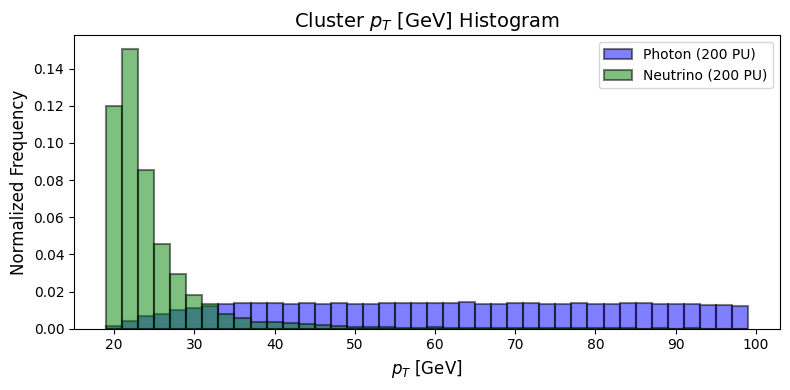

Saved: plots/cl3d_energy_histogram_cl3d_pt_20_100.png


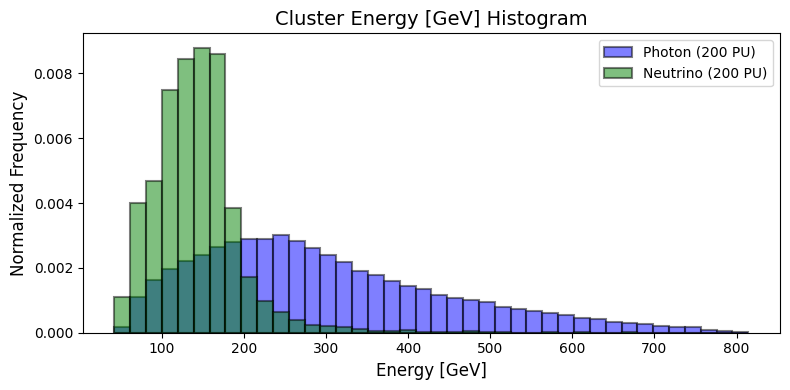

Saved: plots/cl3d_eta_histogram_cl3d_pt_20_100.png


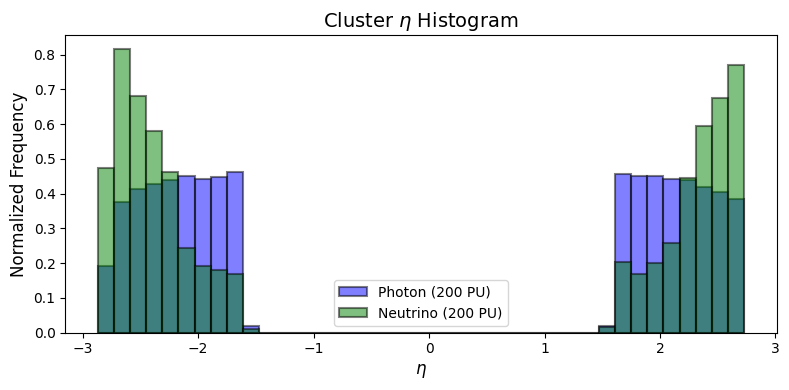

Saved: plots/cl3d_emax1layers_histogram_cl3d_pt_20_100.png


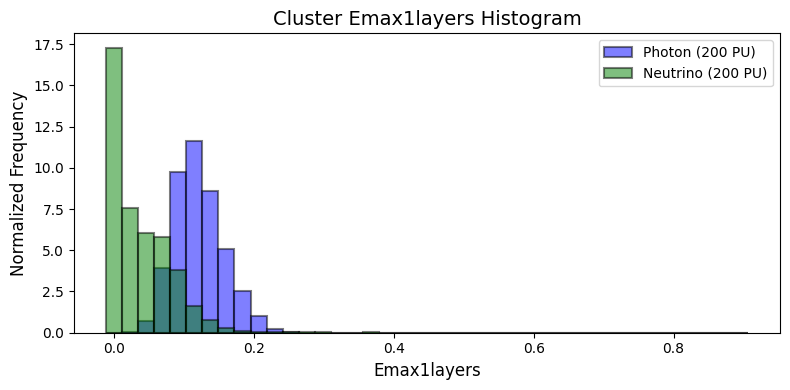

Saved: plots/cl3d_emax3layers_histogram_cl3d_pt_20_100.png


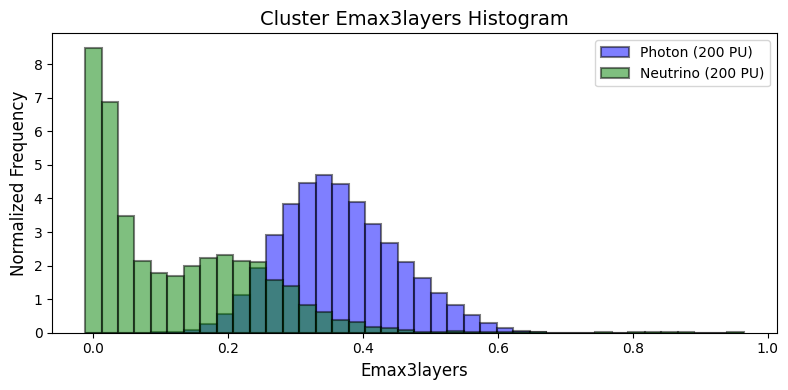

Saved: plots/cl3d_phi_histogram_cl3d_pt_20_100.png


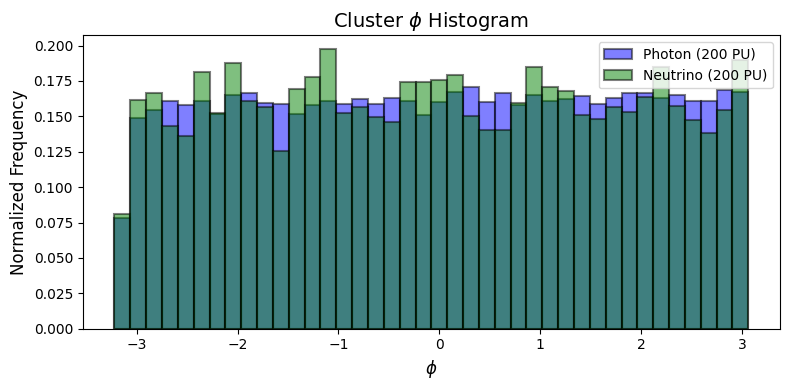

Saved: plots/cl3d_showerlength_histogram_cl3d_pt_20_100.png


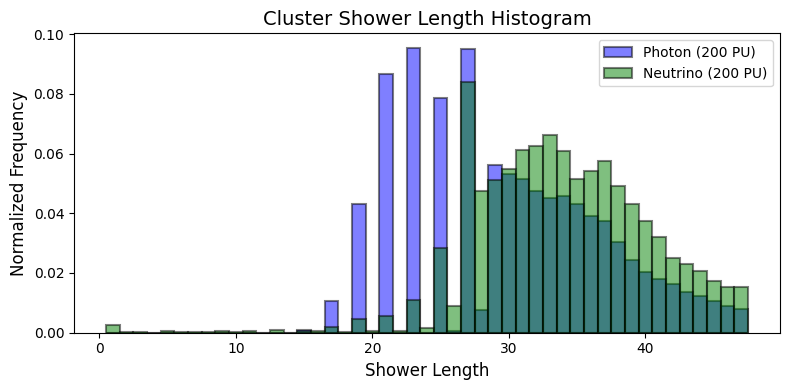

Saved: plots/cl3d_coreshowerlength_histogram_cl3d_pt_20_100.png


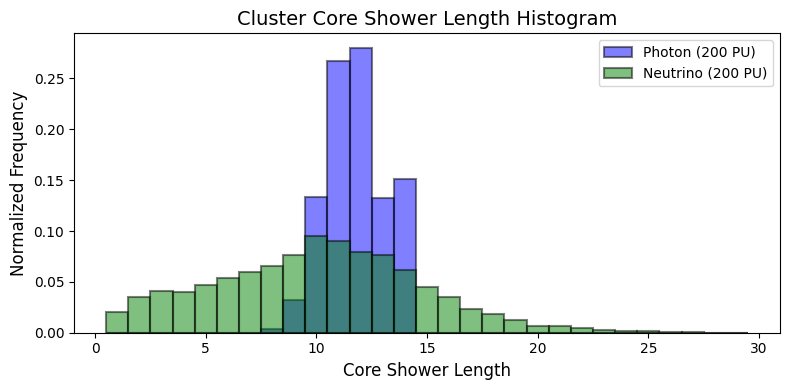

Saved: plots/cl3d_firstlayer_histogram_cl3d_pt_20_100.png


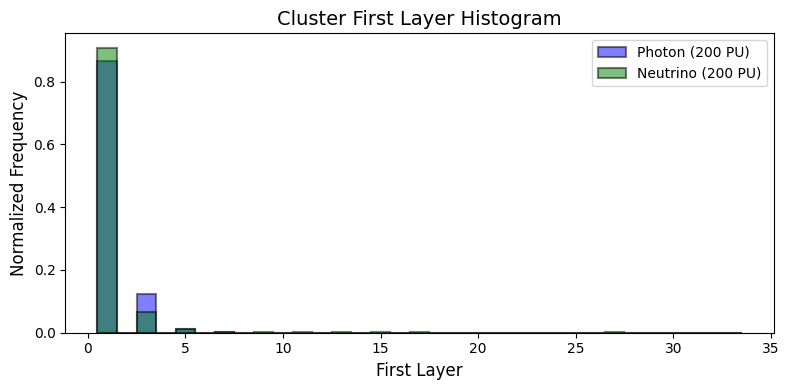

Saved: plots/cl3d_maxlayer_histogram_cl3d_pt_20_100.png


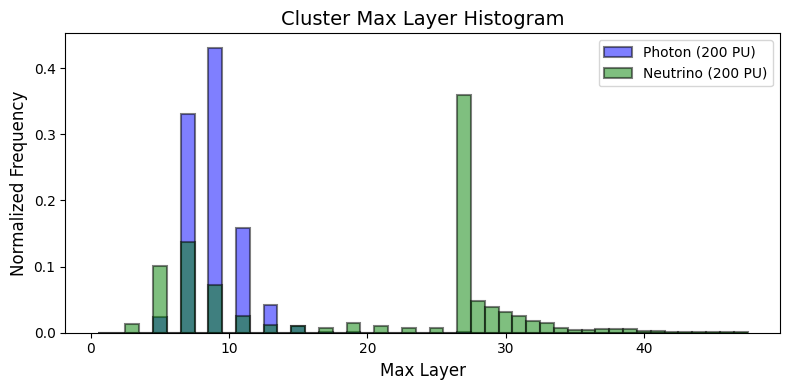

Saved: plots/cl3d_seetot_histogram_cl3d_pt_20_100.png


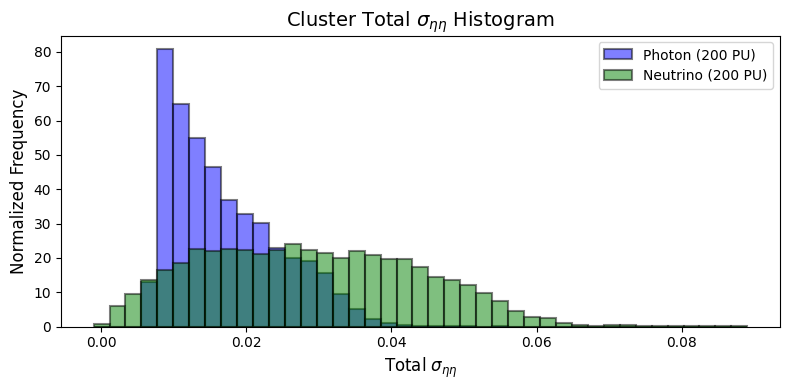

Saved: plots/cl3d_seemax_histogram_cl3d_pt_20_100.png


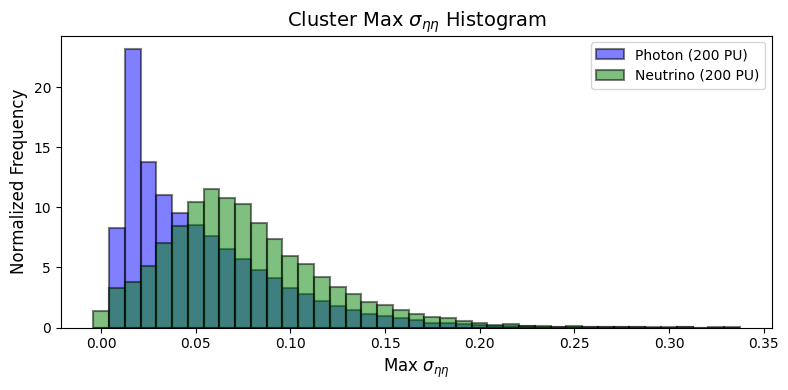

Saved: plots/cl3d_spptot_histogram_cl3d_pt_20_100.png


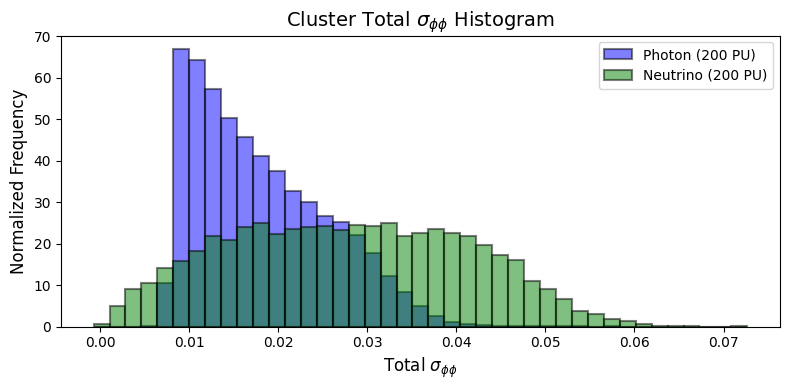

Saved: plots/cl3d_sppmax_histogram_cl3d_pt_20_100.png


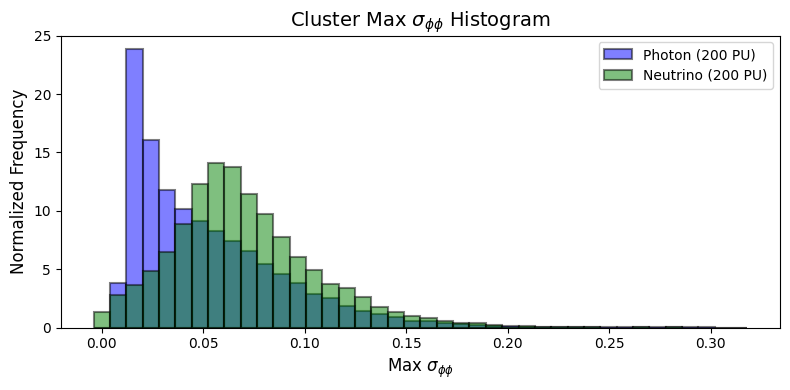

Saved: plots/cl3d_szz_histogram_cl3d_pt_20_100.png


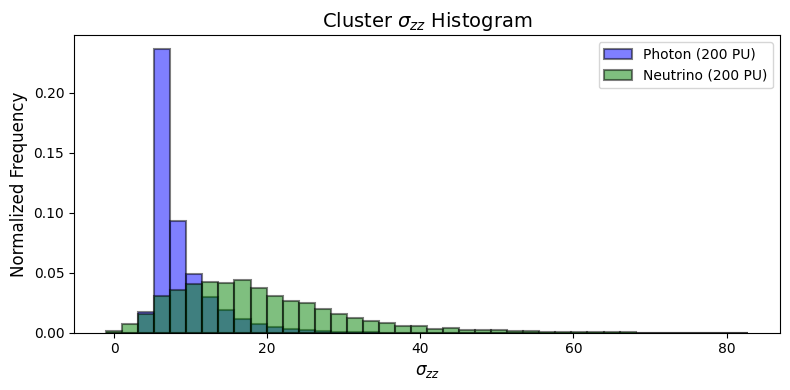

Saved: plots/cl3d_srrtot_histogram_cl3d_pt_20_100.png


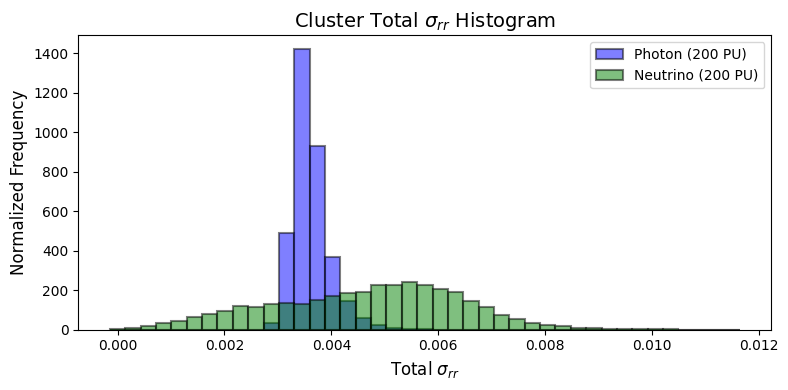

Saved: plots/cl3d_srrmax_histogram_cl3d_pt_20_100.png


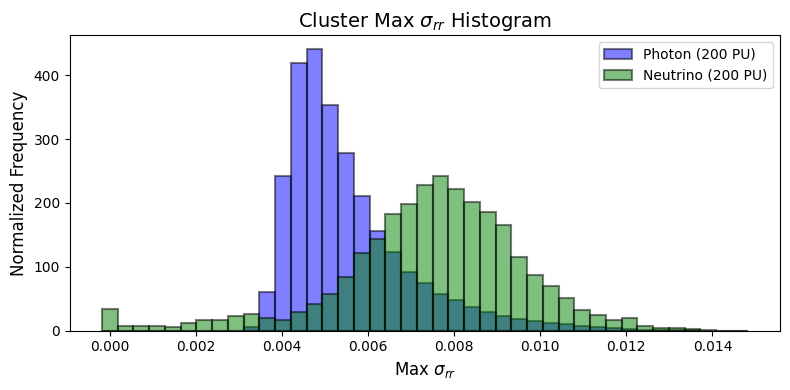

Saved: plots/cl3d_srrmean_histogram_cl3d_pt_20_100.png


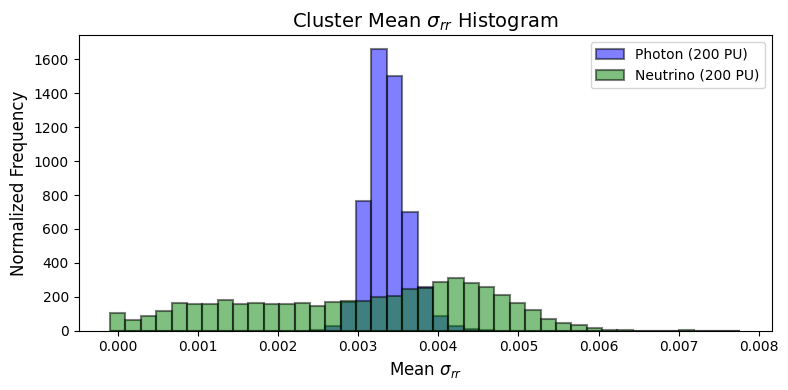

Saved: plots/cl3d_varrr_histogram_cl3d_pt_20_100.png


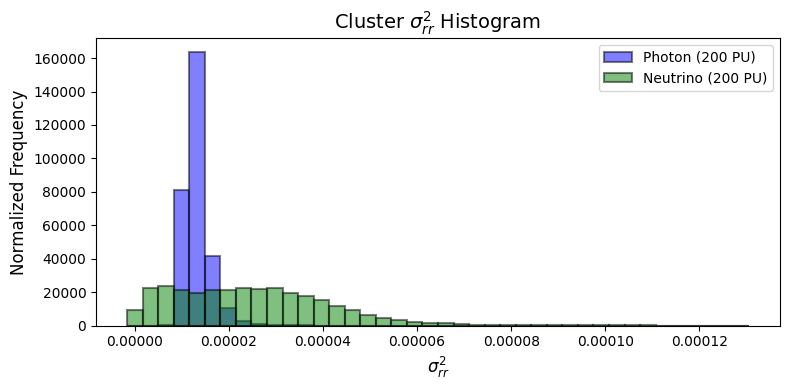

Saved: plots/cl3d_varzz_histogram_cl3d_pt_20_100.png


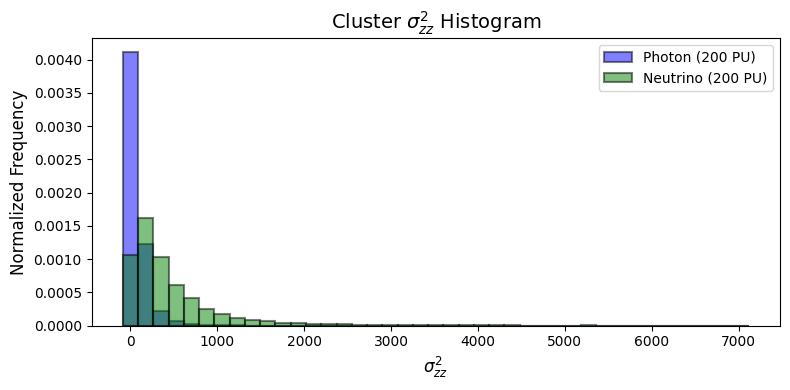

Saved: plots/cl3d_varee_histogram_cl3d_pt_20_100.png


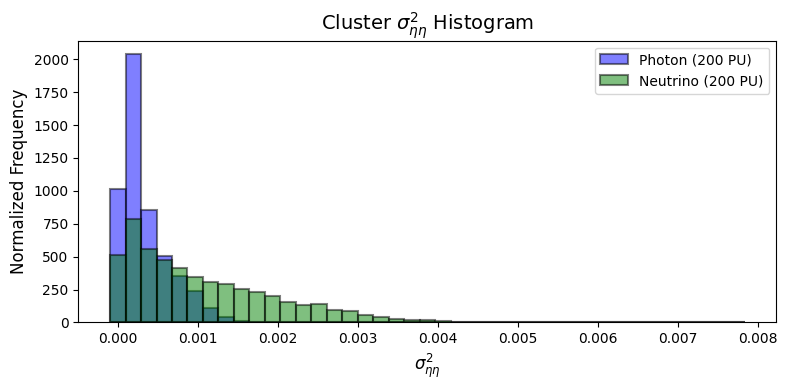

Saved: plots/cl3d_varpp_histogram_cl3d_pt_20_100.png


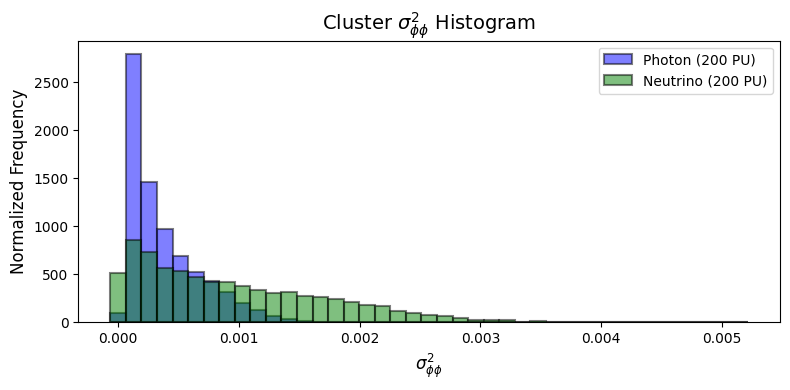

Saved: plots/cl3d_emaxe_histogram_cl3d_pt_20_100.png


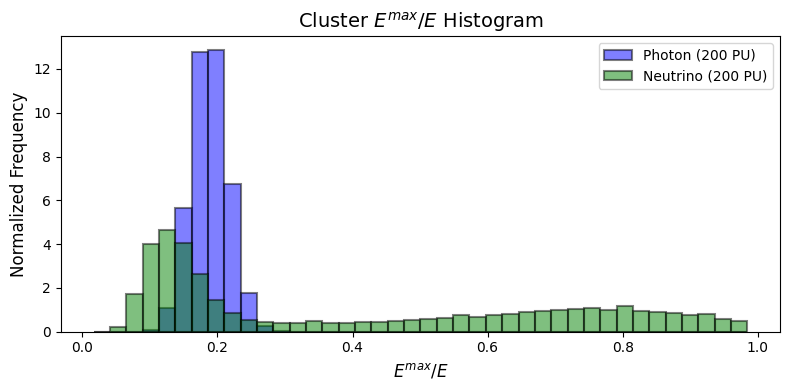

Saved: plots/cl3d_hoe_histogram_cl3d_pt_20_100.png


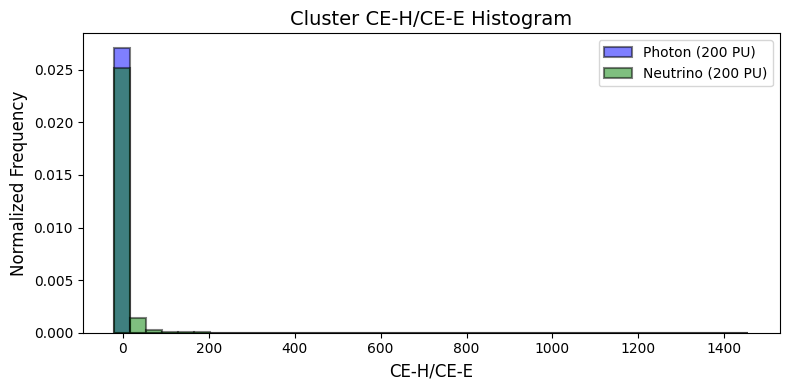

Saved: plots/cl3d_meanz_histogram_cl3d_pt_20_100.png


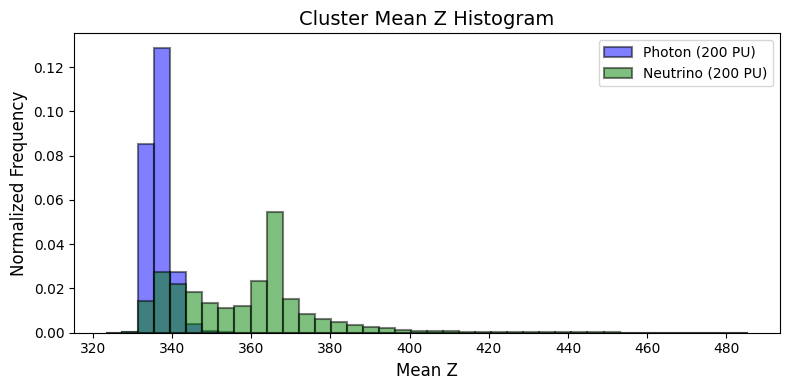

Saved: plots/cl3d_layer10_histogram_cl3d_pt_20_100.png


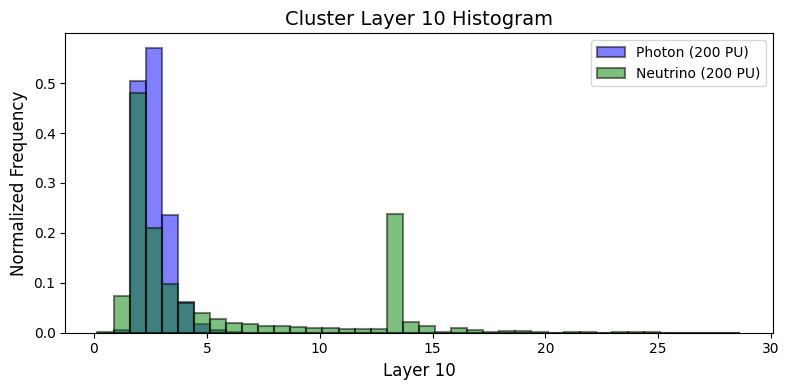

Saved: plots/cl3d_layer50_histogram_cl3d_pt_20_100.png


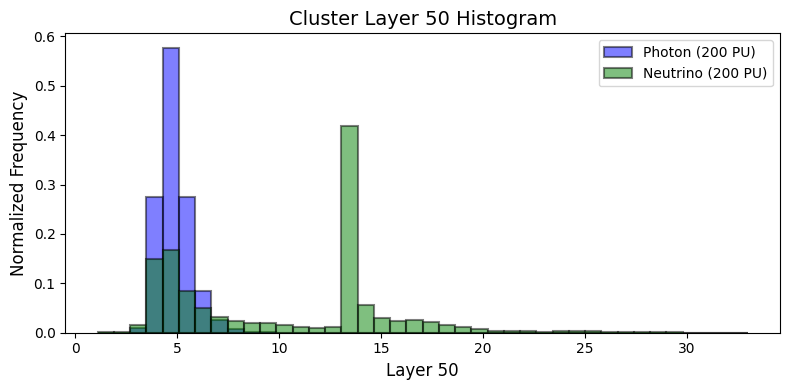

Saved: plots/cl3d_layer90_histogram_cl3d_pt_20_100.png


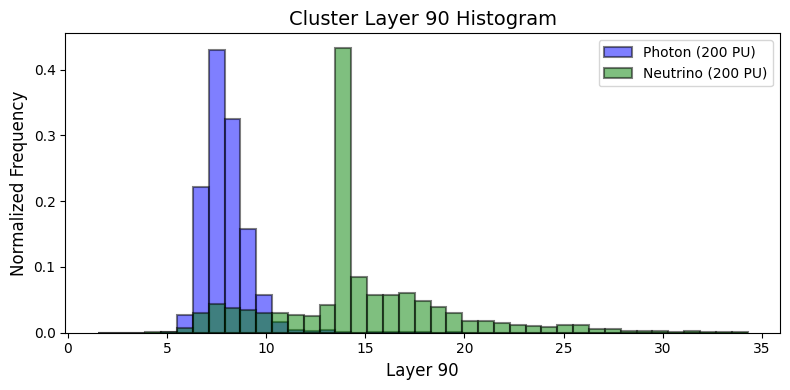

Saved: plots/cl3d_first1layers_histogram_cl3d_pt_20_100.png


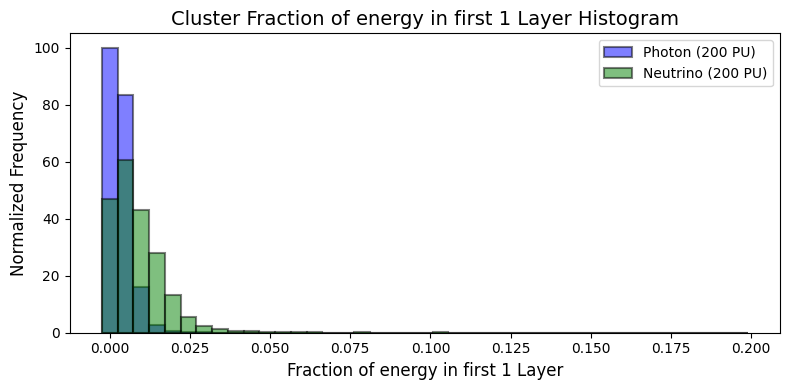

Saved: plots/cl3d_first3layers_histogram_cl3d_pt_20_100.png


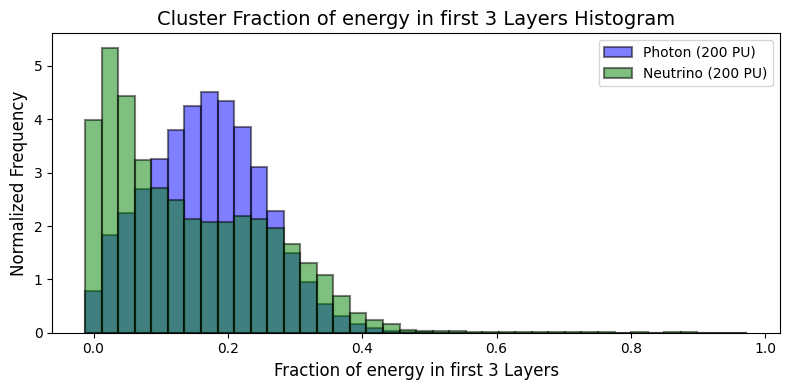

Saved: plots/cl3d_first5layers_histogram_cl3d_pt_20_100.png


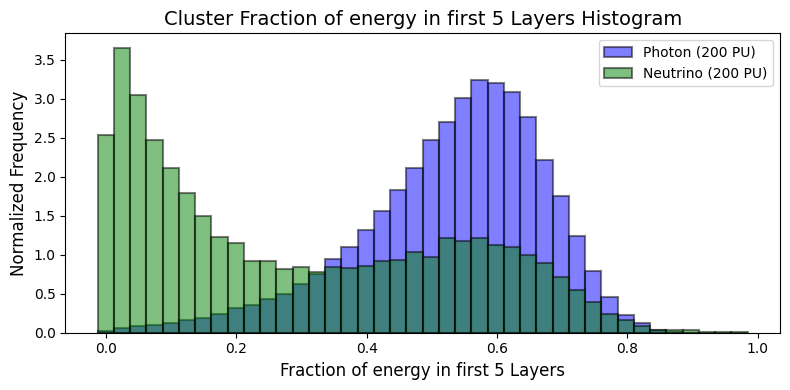

Saved: plots/cl3d_firstHcal1layers_histogram_cl3d_pt_20_100.png


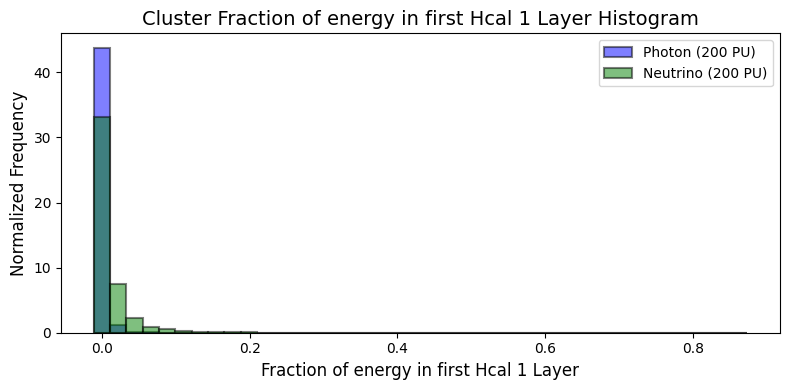

Saved: plots/cl3d_firstHcal3layers_histogram_cl3d_pt_20_100.png


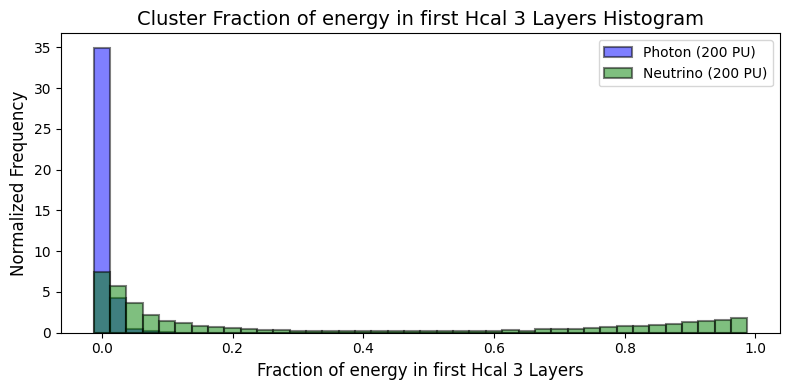

Saved: plots/cl3d_firstHcal5layers_histogram_cl3d_pt_20_100.png


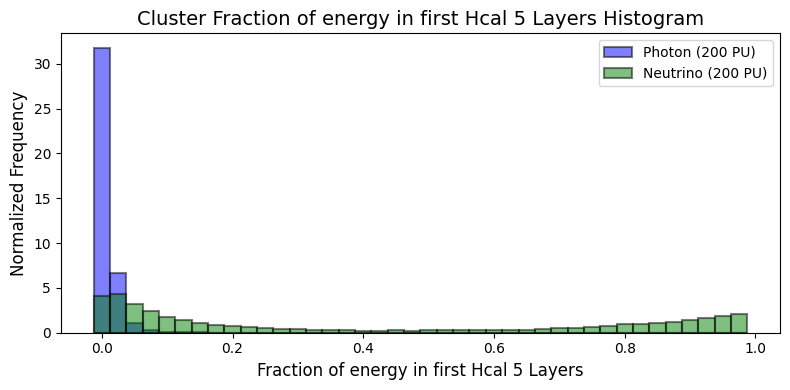

Saved: plots/cl3d_last1layers_histogram_cl3d_pt_20_100.png


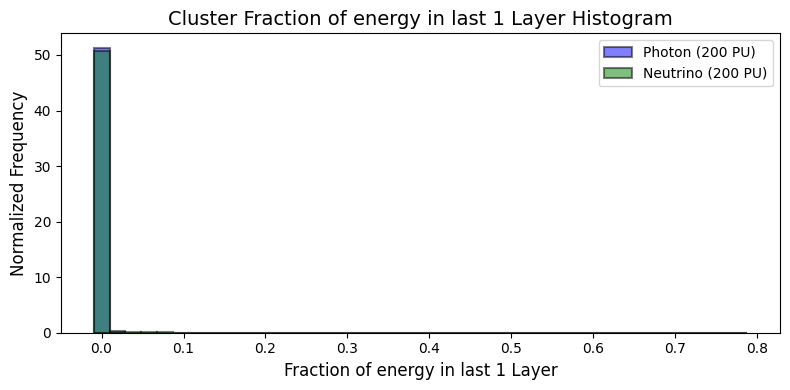

Saved: plots/cl3d_last3layers_histogram_cl3d_pt_20_100.png


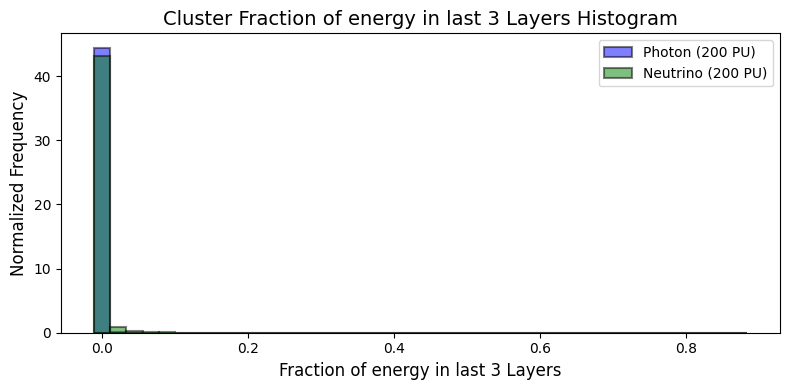

Saved: plots/cl3d_last5layers_histogram_cl3d_pt_20_100.png


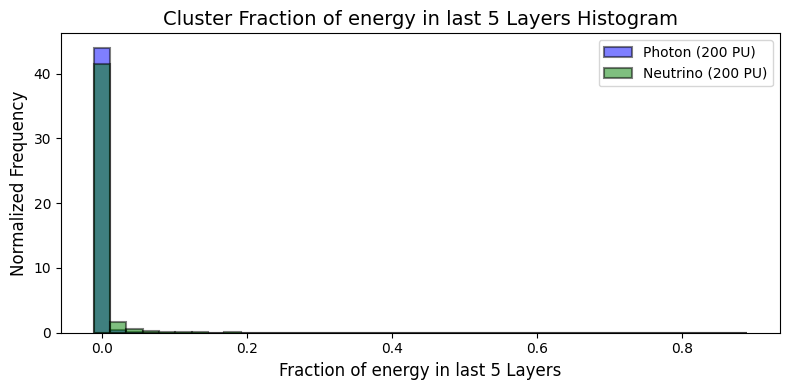

In [24]:
plot_histograms(photonPU200_df_filtered, neutrinoPU200_df_20GeV, variables, cl3d_pt_range=(20, 100))

In [24]:
# Get the common columns between signal and background DataFrames
common_columns = photonPU200_df_filtered.columns.intersection(neutrinoPU200_df_20GeV.columns)

# Keep only the common columns in both DataFrames
neutrinoPU200_df_final = neutrinoPU200_df_20GeV[common_columns]
photonPU200_df_final = photonPU200_df_filtered[common_columns]
photonPU0_df_final = photonPU0_df_filtered[common_columns]

In [32]:
# Assign class labels
neutrinoPU200_df_final['label'] = 0  # Neutrino background
photonPU200_df_final['label'] = 1    # Photon signal with PU=200

# Combine datasets
df_combined = pd.concat([neutrinoPU200_df_final, photonPU200_df_final], ignore_index=True)

/tmp/ipykernel_87891/900917616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photonPU200_df_final['label'] = 1    # Photon signal with PU=200


In [33]:
'''
pt_bins = [20, 30, 40, 50]  # Example bins
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)'''

columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

In [34]:
#filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
filtered_data = df_combined[columns_for_training + ['label']].copy()
feature_importance_by_bin = {}
shap_values_by_bin = {}
mean_shap_values = {}

In [35]:
X = filtered_data[columns_for_training]
y = filtered_data['label']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
def objective(trial, X_train, y_train, X_test, y_test):
    """
    Optuna objective function to optimize XGBoost hyperparameters while keeping memory usage optimized.
    """
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": trial.suggest_int("max_depth", 1, 4),  # Reduced max depth
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Evaluate using AUC
    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

In [37]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=500, n_jobs=1)
print(f"Best parameters: {study.best_params}")

[I 2025-02-11 21:14:45,115] A new study created in memory with name: no-name-3a5404c9-3020-468f-934f-fbee77ee34ab
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:14:47,027] Trial 0 finished with value: 0.9870264552726472 and parameters: {'max_depth': 3, 'gamma': 2.9779860998078256, 'reg_lambda': 4.575234015140046, 'reg_alpha': 0.6231092586738496}. Best is trial 0 with value: 0.9870264552726472.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:14:47,847] Trial 1 finished with value: 0.9371816065845149 and parameters: {'m

[I 2025-02-11 21:15:13,685] Trial 15 finished with value: 0.990610573447946 and parameters: {'max_depth': 4, 'gamma': 0.4897976853119057, 'reg_lambda': 6.377563062982147, 'reg_alpha': 4.898730660660349}. Best is trial 3 with value: 0.991285696985078.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:15:15,851] Trial 16 finished with value: 0.9906106958401786 and parameters: {'max_depth': 4, 'gamma': 0.10424733348573689, 'reg_lambda': 5.987534393678193, 'reg_alpha': 4.946139716485952}. Best is trial 3 with value: 0.991285696985078.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use

[I 2025-02-11 21:15:46,529] Trial 31 finished with value: 0.9912825680010445 and parameters: {'max_depth': 4, 'gamma': 3.5246246989337995, 'reg_lambda': 1.5912303705686033, 'reg_alpha': 3.098575051244037}. Best is trial 27 with value: 0.991291917703335.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:15:48,676] Trial 32 finished with value: 0.9913004266242016 and parameters: {'max_depth': 4, 'gamma': 1.8110360540570112, 'reg_lambda': 1.0357743312838423, 'reg_alpha': 2.3227060798423467}. Best is trial 32 with value: 0.9913004266242016.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:16:17,349] Trial 47 finished with value: 0.991291489330521 and parameters: {'max_depth': 4, 'gamma': 0.33618888646391687, 'reg_lambda': 1.4216956895969606, 'reg_alpha': 0.9157658850451417}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:16:19,496] Trial 48 finished with value: 0.991297571692341 and parameters: {'max_depth': 4, 'gamma': 1.597588014301238, 'reg_lambda': 1.906484448492578, 'reg_alpha': 1.3922128278759387}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn(

[I 2025-02-11 21:16:50,919] Trial 63 finished with value: 0.9809149747439373 and parameters: {'max_depth': 2, 'gamma': 0.057895330921987176, 'reg_lambda': 1.3783540196083823, 'reg_alpha': 0.23337126057492164}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:16:53,088] Trial 64 finished with value: 0.9913079643893095 and parameters: {'max_depth': 4, 'gamma': 0.2425440600683399, 'reg_lambda': 1.7476434802970415, 'reg_alpha': 0.2444647259926632}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings

[I 2025-02-11 21:17:24,984] Trial 79 finished with value: 0.9913060273991934 and parameters: {'max_depth': 4, 'gamma': 1.4133016239066727, 'reg_lambda': 1.9193603644404997, 'reg_alpha': 0.547608203019614}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:17:27,150] Trial 80 finished with value: 0.9912851967733449 and parameters: {'max_depth': 4, 'gamma': 0.4241083356094442, 'reg_lambda': 3.233430066526507, 'reg_alpha': 1.2214696184260483}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:17:59,069] Trial 95 finished with value: 0.9912984656877794 and parameters: {'max_depth': 4, 'gamma': 1.544304542734681, 'reg_lambda': 3.2080486580674643, 'reg_alpha': 0.15922473262204562}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:18:01,290] Trial 96 finished with value: 0.9912910476542033 and parameters: {'max_depth': 4, 'gamma': 1.432450666012633, 'reg_lambda': 2.862419781525765, 'reg_alpha': 1.2787634380021666}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:18:32,568] Trial 111 finished with value: 0.9912748918794999 and parameters: {'max_depth': 4, 'gamma': 2.375662192833463, 'reg_lambda': 5.632520927353051, 'reg_alpha': 0.6760755448238359}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:18:34,749] Trial 112 finished with value: 0.9913136476460234 and parameters: {'max_depth': 4, 'gamma': 2.4900648925717936, 'reg_lambda': 1.0232158298657252, 'reg_alpha': 0.5954410716680678}. Best is trial 37 with value: 0.9913157549209846.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.wa

[I 2025-02-11 21:19:09,714] Trial 127 finished with value: 0.9913117931376292 and parameters: {'max_depth': 4, 'gamma': 3.1965765052451474, 'reg_lambda': 1.6830532679428318, 'reg_alpha': 0.07980125581074704}. Best is trial 115 with value: 0.9913164147747603.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:19:11,866] Trial 128 finished with value: 0.9913113035686988 and parameters: {'max_depth': 4, 'gamma': 2.996367718218022, 'reg_lambda': 1.494194698638637, 'reg_alpha': 0.32146245492880754}. Best is trial 115 with value: 0.9913164147747603.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warning

[I 2025-02-11 21:20:00,316] Trial 143 finished with value: 0.9913144006243237 and parameters: {'max_depth': 4, 'gamma': 4.24028497870347, 'reg_lambda': 1.6619284648750223, 'reg_alpha': 0.3702934028236354}. Best is trial 141 with value: 0.9913168218619686.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:20:02,445] Trial 144 finished with value: 0.9913162790790241 and parameters: {'max_depth': 4, 'gamma': 4.141995822784774, 'reg_lambda': 1.9030521240358433, 'reg_alpha': 0.26638387892475346}. Best is trial 141 with value: 0.9913168218619686.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.

[I 2025-02-11 21:20:36,425] Trial 159 finished with value: 0.9913128387930079 and parameters: {'max_depth': 4, 'gamma': 3.272125824859729, 'reg_lambda': 1.567697321780619, 'reg_alpha': 0.20685667690510312}. Best is trial 148 with value: 0.9913170560036312.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:20:39,126] Trial 160 finished with value: 0.9913065595393352 and parameters: {'max_depth': 4, 'gamma': 2.825945962308268, 'reg_lambda': 1.9237655296932297, 'reg_alpha': 0.5473555759661968}. Best is trial 148 with value: 0.9913170560036312.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.

[I 2025-02-11 21:21:11,563] Trial 175 finished with value: 0.9913090020625858 and parameters: {'max_depth': 4, 'gamma': 4.410788272315351, 'reg_lambda': 1.1831194910766525, 'reg_alpha': 0.3967583187647042}. Best is trial 169 with value: 0.9913192324568108.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:21:13,733] Trial 176 finished with value: 0.9913153637979804 and parameters: {'max_depth': 4, 'gamma': 4.287307482941311, 'reg_lambda': 1.7099833282132308, 'reg_alpha': 0.21060554787580435}. Best is trial 169 with value: 0.9913192324568108.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings

[I 2025-02-11 21:21:46,944] Trial 191 finished with value: 0.9913166116666128 and parameters: {'max_depth': 4, 'gamma': 4.715872975607876, 'reg_lambda': 1.226674566307598, 'reg_alpha': 0.6677111302116823}. Best is trial 169 with value: 0.9913192324568108.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:21:49,131] Trial 192 finished with value: 0.9913175881437728 and parameters: {'max_depth': 4, 'gamma': 4.69886083905592, 'reg_lambda': 1.244394617748005, 'reg_alpha': 0.6707782936669505}. Best is trial 169 with value: 0.9913192324568108.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:22:20,983] Trial 207 finished with value: 0.9913138551806785 and parameters: {'max_depth': 4, 'gamma': 4.82238259420151, 'reg_lambda': 1.5808317581010165, 'reg_alpha': 0.5393096300964597}. Best is trial 203 with value: 0.9913238248262342.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:22:23,151] Trial 208 finished with value: 0.9913198018467625 and parameters: {'max_depth': 4, 'gamma': 4.672227895696834, 'reg_lambda': 1.1360754034315486, 'reg_alpha': 0.6359792132955567}. Best is trial 203 with value: 0.9913238248262342.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.w

[I 2025-02-11 21:22:59,819] Trial 223 finished with value: 0.9913173646449133 and parameters: {'max_depth': 4, 'gamma': 4.952801528960543, 'reg_lambda': 1.0311096834007625, 'reg_alpha': 0.9022306969828462}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:23:01,973] Trial 224 finished with value: 0.9913166143273134 and parameters: {'max_depth': 4, 'gamma': 4.963794545233492, 'reg_lambda': 1.0445107969311633, 'reg_alpha': 0.95168521517807}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:23:33,119] Trial 239 finished with value: 0.9870437737735603 and parameters: {'max_depth': 3, 'gamma': 4.991113479400536, 'reg_lambda': 1.0017753029685184, 'reg_alpha': 0.8559263360076862}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:23:38,962] Trial 240 finished with value: 0.9913169495756028 and parameters: {'max_depth': 4, 'gamma': 4.839980675439853, 'reg_lambda': 1.15433685732469, 'reg_alpha': 0.8181124588977132}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:24:11,399] Trial 255 finished with value: 0.9913140041799182 and parameters: {'max_depth': 4, 'gamma': 4.653374641328949, 'reg_lambda': 1.3122965588025497, 'reg_alpha': 0.8471684517987896}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:24:13,914] Trial 256 finished with value: 0.9913137487526502 and parameters: {'max_depth': 4, 'gamma': 4.767449385234279, 'reg_lambda': 1.1673606552002198, 'reg_alpha': 1.01893579922217}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:25:01,244] Trial 271 finished with value: 0.9913144378741336 and parameters: {'max_depth': 4, 'gamma': 4.68209263779324, 'reg_lambda': 1.5529675851891276, 'reg_alpha': 0.6738164317548745}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:25:03,438] Trial 272 finished with value: 0.9913169761826098 and parameters: {'max_depth': 4, 'gamma': 4.425247651678351, 'reg_lambda': 1.2645227887711, 'reg_alpha': 0.5676500335577885}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("

[I 2025-02-11 21:25:39,024] Trial 287 finished with value: 0.9913165238634893 and parameters: {'max_depth': 4, 'gamma': 4.55130740569837, 'reg_lambda': 1.3356402223859958, 'reg_alpha': 0.565256618537713}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:25:41,192] Trial 288 finished with value: 0.9913166835055318 and parameters: {'max_depth': 4, 'gamma': 4.634693662721838, 'reg_lambda': 1.1818577302739421, 'reg_alpha': 0.6831296232715276}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn

[I 2025-02-11 21:26:14,366] Trial 303 finished with value: 0.9913160183303547 and parameters: {'max_depth': 4, 'gamma': 4.519326169505126, 'reg_lambda': 1.4874520174347057, 'reg_alpha': 0.4760234337845336}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:26:16,538] Trial 304 finished with value: 0.9913156351894526 and parameters: {'max_depth': 4, 'gamma': 4.645055329282279, 'reg_lambda': 1.3018540355707144, 'reg_alpha': 0.6521536109934766}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.wa

[I 2025-02-11 21:26:48,110] Trial 319 finished with value: 0.9913149966212826 and parameters: {'max_depth': 4, 'gamma': 4.897865143192428, 'reg_lambda': 1.53269334250307, 'reg_alpha': 0.6733583218185801}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:26:50,184] Trial 320 finished with value: 0.9913098694510167 and parameters: {'max_depth': 4, 'gamma': 4.70291898959017, 'reg_lambda': 1.005086882621501, 'reg_alpha': 2.284643096234492}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`

[I 2025-02-11 21:27:23,252] Trial 335 finished with value: 0.9913135332358927 and parameters: {'max_depth': 4, 'gamma': 4.556167131342408, 'reg_lambda': 1.3878171127179457, 'reg_alpha': 0.7141524850021345}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:27:25,438] Trial 336 finished with value: 0.9913201131487455 and parameters: {'max_depth': 4, 'gamma': 4.6645314733132155, 'reg_lambda': 1.161047440293087, 'reg_alpha': 0.5377552003534273}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.wa

[I 2025-02-11 21:27:59,579] Trial 351 finished with value: 0.9912865111594948 and parameters: {'max_depth': 4, 'gamma': 4.560565392364051, 'reg_lambda': 3.6709451498386896, 'reg_alpha': 0.78885086795683}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:28:01,756] Trial 352 finished with value: 0.9913090393123957 and parameters: {'max_depth': 4, 'gamma': 4.550092939769105, 'reg_lambda': 1.1844687038972215, 'reg_alpha': 0.37072692190014744}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:28:34,805] Trial 367 finished with value: 0.9913060673097039 and parameters: {'max_depth': 4, 'gamma': 4.603387225694481, 'reg_lambda': 1.3352299321709202, 'reg_alpha': 0.47276597063061215}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:28:36,984] Trial 368 finished with value: 0.9913049232083992 and parameters: {'max_depth': 4, 'gamma': 4.8199450339072385, 'reg_lambda': 1.6056660439706998, 'reg_alpha': 0.676639669019664}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.w

[I 2025-02-11 21:29:09,267] Trial 383 finished with value: 0.991319769918354 and parameters: {'max_depth': 4, 'gamma': 4.838692880019172, 'reg_lambda': 1.1683096295232631, 'reg_alpha': 0.5891068077285045}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:29:11,429] Trial 384 finished with value: 0.9913049657796106 and parameters: {'max_depth': 4, 'gamma': 4.7392087376846685, 'reg_lambda': 1.3845044189772255, 'reg_alpha': 0.505044066393699}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:29:43,250] Trial 399 finished with value: 0.9913134028615581 and parameters: {'max_depth': 4, 'gamma': 4.626773363838553, 'reg_lambda': 1.4702255310740546, 'reg_alpha': 0.6497697115935819}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:29:45,445] Trial 400 finished with value: 0.9913169868254126 and parameters: {'max_depth': 4, 'gamma': 4.810708385973347, 'reg_lambda': 1.2867712241540827, 'reg_alpha': 0.528245438172572}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:30:17,253] Trial 415 finished with value: 0.9913098534868126 and parameters: {'max_depth': 4, 'gamma': 4.470195913236429, 'reg_lambda': 1.1442517958808176, 'reg_alpha': 0.3167721026460287}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:30:19,657] Trial 416 finished with value: 0.9913056149905836 and parameters: {'max_depth': 4, 'gamma': 4.521201409264486, 'reg_lambda': 1.466189016299381, 'reg_alpha': 0.4164718222166754}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:30:52,781] Trial 431 finished with value: 0.9913067484490855 and parameters: {'max_depth': 4, 'gamma': 4.751619230728161, 'reg_lambda': 1.4792020173981208, 'reg_alpha': 1.5271899597033365}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:30:55,012] Trial 432 finished with value: 0.9912799312466422 and parameters: {'max_depth': 4, 'gamma': 4.936363453869692, 'reg_lambda': 5.376594534396029, 'reg_alpha': 0.23692369490640938}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.wa

[I 2025-02-11 21:31:32,943] Trial 447 finished with value: 0.9912843240635123 and parameters: {'max_depth': 4, 'gamma': 4.604287855745132, 'reg_lambda': 5.014682445932181, 'reg_alpha': 0.2942678253885185}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:31:35,098] Trial 448 finished with value: 0.9913198710249811 and parameters: {'max_depth': 4, 'gamma': 4.702763584474675, 'reg_lambda': 1.1562409024234706, 'reg_alpha': 0.5203883437773539}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

[I 2025-02-11 21:32:09,860] Trial 463 finished with value: 0.9913171890386666 and parameters: {'max_depth': 4, 'gamma': 4.797588131793512, 'reg_lambda': 1.4213195006573844, 'reg_alpha': 0.36247232276112124}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:32:12,053] Trial 464 finished with value: 0.9913169070043915 and parameters: {'max_depth': 4, 'gamma': 4.997324337015105, 'reg_lambda': 1.2922844556571536, 'reg_alpha': 0.5159708283362425}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.w

[I 2025-02-11 21:32:44,997] Trial 479 finished with value: 0.9912916915437747 and parameters: {'max_depth': 4, 'gamma': 4.933411215979077, 'reg_lambda': 3.425220542618348, 'reg_alpha': 0.5483399223912042}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:32:47,186] Trial 480 finished with value: 0.9913092628112552 and parameters: {'max_depth': 4, 'gamma': 4.998807153378701, 'reg_lambda': 1.1479766590794866, 'reg_alpha': 0.37352975056810506}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.wa

[I 2025-02-11 21:33:19,866] Trial 495 finished with value: 0.9912861439827969 and parameters: {'max_depth': 4, 'gamma': 4.263239007817189, 'reg_lambda': 1.0082114700642448, 'reg_alpha': 3.1318303067886184}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-11 21:33:22,307] Trial 496 finished with value: 0.9913086029574796 and parameters: {'max_depth': 4, 'gamma': 4.895397522636654, 'reg_lambda': 1.326770614390516, 'reg_alpha': 0.1824057171488734}. Best is trial 211 with value: 0.991328896121785.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.war

Best parameters: {'max_depth': 4, 'gamma': 4.888840939958652, 'reg_lambda': 1.006181369852792, 'reg_alpha': 0.703982194385327}


In [57]:
# Train final model with the best parameters
best_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": 4,
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": 4.9,
        "reg_lambda": 1,
        "reg_alpha": 0.7
}
best_params.update({"n_jobs": 20})  # Optionally update with additional parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=20, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [58]:
# Predict and evaluate
y_pred_final = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Accuracy: {accuracy:.4f}")

Final Model Accuracy: 0.9825


In [59]:
# -------------------- SHAP Analysis --------------------
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

 98%|===================| 33819/34347 [00:39<00:00]        

In [60]:
# Compute Mean Absolute SHAP Value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
for feature, shap_mean in zip(columns_for_training, mean_abs_shap):
    if feature not in mean_shap_values:
        mean_shap_values[feature] = []
    mean_shap_values[feature].append(shap_mean)

In [61]:
if len(shap_values.shape) == 3:  # Multi-class case
    shap_values = shap_values[:, :, 1]  # Select class index 1

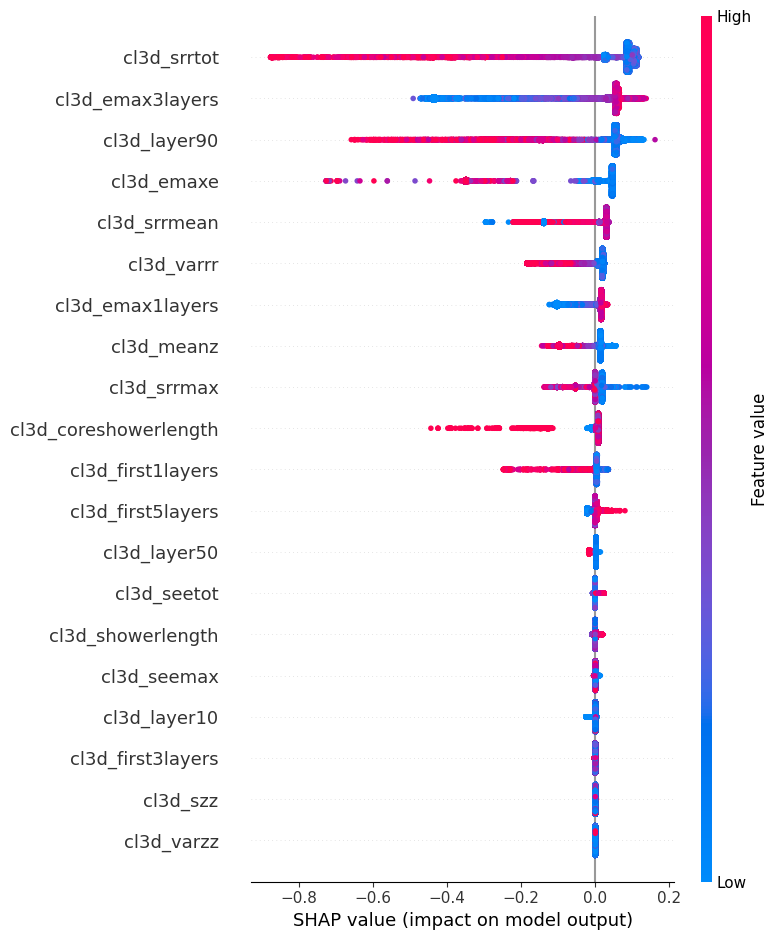

Saved: shap_summary.png


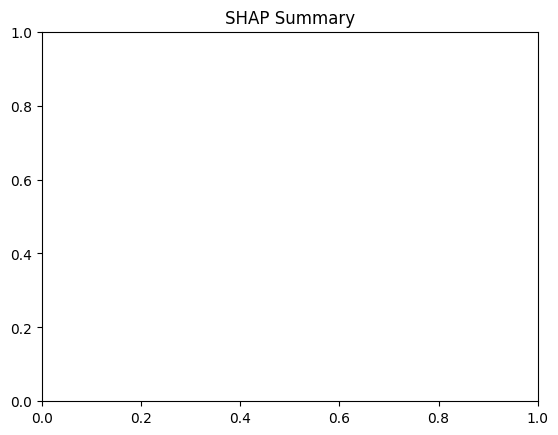

In [62]:
# Generate SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test)
plt.title(f"SHAP Summary")
filename = f"shap_summary.png"
plt.savefig(filename, dpi=300)
print(f"Saved: {filename}")
plt.show()

In [63]:
# Generate SHAP dependence plots for the top three features
# Sort features by their mean absolute SHAP values and pick the top three.
sorted_features = sorted(mean_shap_values, key=mean_shap_values.get, reverse=True)
for feature in sorted_features[:3]:
    plt.figure()
    shap.dependence_plot(feature, shap_values.values, X_test, show=False)
    filename = f"shap_dependence_{feature}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
'''
for pt_bin in range(len(pt_bins) - 1):  
    print(f"Optimizing for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")

    bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
    X = bin_data[columns_for_training]
    y = bin_data['label']

    # Check class balance
    class_counts = y.value_counts()
    if len(class_counts) < 2:  
        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
        continue

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100, n_jobs=1)  # Reduce trials for efficiency

    print(f"Best parameters for pT bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}: {study.best_params}")

    # Train final model with best parameters
    best_params = study.best_params
    best_params.update({"n_jobs": 20})  
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)

    # SHAP analysis
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)
    shap_values_by_bin[pt_bin] = shap_values

    # Compute Mean Absolute SHAP Value for each feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Store feature importance
    for feature, shap_mean in zip(columns_for_training, mean_abs_shap):
        if feature not in mean_shap_values:
            mean_shap_values[feature] = []
        mean_shap_values[feature].append(shap_mean)

    # Generate SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Summary for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    filename = f"{pt_bins[pt_bin]}_shap_summary_20GeV.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()

    # Generate SHAP dependence plots for the top features
    for feature in columns_for_training[:3]:  
        plt.figure()
        shap.dependence_plot(feature, shap_values.values, X_test, show=False)
        filename = f"{pt_bins[pt_bin]}_shap_dependence_{feature}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
'''

In [ ]:
def quantize_feature(series, n_mantissa_bits, value_range=None):
    # Determine the range if not provided.
    if value_range is None:
        min_val, max_val = series.min(), series.max()
    else:
        min_val, max_val = value_range

    n_levels = 2 ** n_mantissa_bits
    normalized = (series - min_val) / (max_val - min_val)
    
    # Quantize: multiply by number of levels, floor it to truncate,
    # then divide back by number of levels and rescale.
    quantized = np.floor(normalized * n_levels) / n_levels
    quantized = quantized * (max_val - min_val) + min_val
    
    return quantized

In [ ]:
most_important_features = list(mean_shap_values.keys())[:10]
n_mantissa_bits = 4

quantized_data = filtered_data.copy()
for feature in columns_for_training:
    quantized_data[feature] = quantize_feature(quantized_data[feature], n_mantissa_bits)

X_quantized = quantized_data[columns_for_training]
y_quantized = quantized_data['label']
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantized, y_quantized, test_size=0.2, random_state=42)

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_q, y_train_q)
explainer = shap.Explainer(best_model, X_train_q)
shap_values = explainer(X_test_q)
shap.summary_plot(shap_values, X_test_q)
plt.show()

In [ ]:
# --- ROC Curve Plotting ---

# Obtain predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test_q)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_q, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [41]:
print(list(mean_shap_values.keys())[:10])

['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot']


# 